In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats

In [19]:
# Using data from Microsoft
msft = yf.Ticker("MSFT")
msft_history = msft.history(start="1995-01-01", end="2022-12-31", interval="1d")
msft_returns = np.log(msft_history["Close"] / msft_history["Close"].shift(1)).dropna()

#Fitting
trading_days_per_yr = 252
mu = msft_returns.mean()
std = msft_returns.std()
msft_fitted_return_dist = stats.norm(loc=mu, scale=std)
print(f"Annualized expected return: {mu * trading_days_per_yr}")
print(f"Annualized return volatility: {std * np.sqrt(trading_days_per_yr)}")

Annualized expected return: 0.16531683094914534
Annualized return volatility: 0.3154558894217763


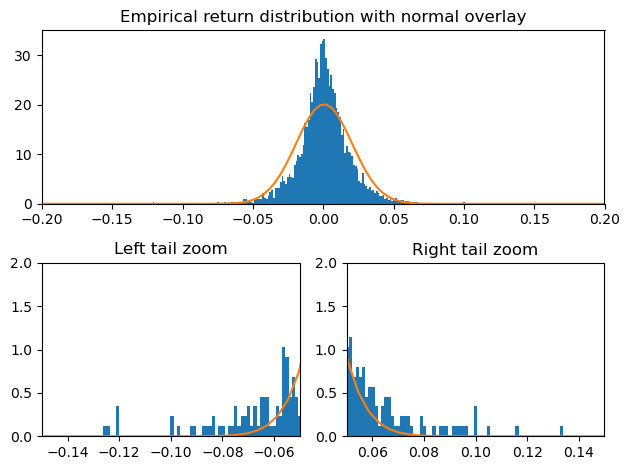

In [20]:
# Plotting
fig = plt.figure()
spec = fig.add_gridspec(2, 2)
ax_main = fig.add_subplot(spec[0, :])
ax_lt = fig.add_subplot(spec[1, 0])
ax_rt = fig.add_subplot(spec[1, 1])

interval = (-0.2, 0.2)
for ax in (ax_main, ax_lt, ax_rt):
    hist = ax.hist(msft_returns, bins=int(len(msft_returns)/25), density=True)
    sample = np.linspace(*interval, num=100)
    interval = (-0.20, 0.20)
    ax.set_xlim(*interval)
    ax.plot(sample, msft_fitted_return_dist.pdf(sample))

ax_main.set_title("Empirical return distribution with normal overlay")
ax_lt.set_title("Left tail zoom")
ax_lt.set_ylim((0, 2))
ax_lt.set_xlim((-0.15, -0.05))
ax_rt.set_title("Right tail zoom")
ax_rt.set_xlim((0.05, 0.15))
ax_rt.set_ylim((0, 2))
fig.tight_layout()

In [21]:
# Check is valid density
hist_y, hist_x, _ = hist
bar_widths = np.diff(hist_x)
(hist_y * bar_widths).sum()

1.0

In [22]:
# Analyzing the graphs
msft_returns.sort_values().head()

Date
2000-04-24 00:00:00-04:00   -0.169577
2020-03-16 00:00:00-04:00   -0.159453
2000-04-03 00:00:00-04:00   -0.156310
2000-11-30 00:00:00-05:00   -0.125740
2009-01-22 00:00:00-05:00   -0.124579
Name: Close, dtype: float64

In [25]:
msft_history["Close"].loc["2000-11-30"] / msft_history["Close"].loc["2000-04-03"] - 1

-0.36863851799405756

A change by -36% here.

In [26]:
min_return = msft_returns.min()
prob_of_observing_lte_min_return = msft_fitted_return_dist.cdf(min_return)
min_return, prob_of_observing_lte_min_return

(-0.16957683199991777, 5.33244815410765e-18)

Extremely small number, but not actually as small as APPL's.

In [27]:
# Checking if normal
skew = msft_returns.skew()
# Fisher subtracts 3 so if it was normal kurtosis would = 0
kurt_fisher = stats.kurtosis(msft_returns, fisher=True) 

print(f"Skew = {skew}")
print(f"Kurtosis = {kurt_fisher}")

Skew = -0.08640829435529625
Kurtosis = 7.193774473830716


The kurtosis is not too high (at least compared to APPL), and there is a negative skew. This does indicate that the tails are a bit fatter than normal, which matches visually compared to APPL's data. So MSFT does not completely follow a normal distribution because of the fat tails.

In [31]:
# Volatility
vol_window = int(trading_days_per_yr / 2)
msft_vol_history = msft_returns.rolling(window=vol_window, min_periods=vol_window).std().dropna() * np.sqrt(trading_days_per_yr)

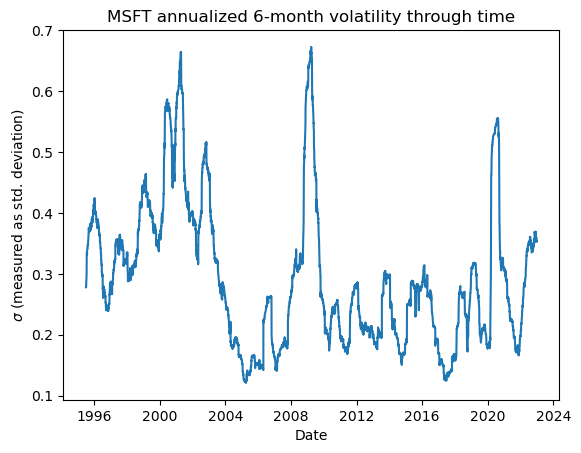

In [32]:
# Plotting
fig, ax = plt.subplots()
ax.plot(msft_vol_history)
ax.set_title("MSFT annualized 6-month volatility through time")
ax.set_xlabel("Date")
ax.set_ylabel("$\sigma$ (measured as std. deviation)");

The volatility here is clearly not constant. While it appears to spike more often compared to APPL, the volatility is generally lower. However, due to the non-constant volatility, Black-Scholes is not always reliable. Furthermore, from earlier, we know that Microsoft does not follow a normal distribution.

In general, these results are more favorable compared to APPL, so Black-Scholes may be more reasonable. But once again, the issues are clearly still present.